## In this notebook

- Create xG model.

In [1]:
from enum import Enum
from pathlib import Path

# data wrangling
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from scipy.ndimage import gaussian_filter 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# utils
from playground.utils import (
    SeasonType,
    get_angle,
    get_combination,
    get_df_players_on_ice_per_sec,
    get_distance_from_goal,
    get_normalized_coordinate,
    get_second,
    get_strength,
    get_time_between_shots,
    get_time_in_period_seconds,
)

# other
from tqdm.notebook import tqdm

In [2]:
DATA_FOLDER_PATH = Path("/usr/src/app/data/")
DATA_FILE_NAME_SHOTS = "shots/20240629_base_shots.parquet"
DATA_FILE_NAME_PENALTIES = "penalties/20240630_base_penalties.parquet"
DATA_FILE_NAME_PLAYERS_2023 = "players/players_general_info_2023.csv"

## Read data

In [3]:
# shots

cols_to_keep = [
    "game_id",
    "away_team_id",
    "home_team_id",
    "period",
    "period_type",
    "time_in_period",
    "situation_code",
    "home_team_defending_side",
    "event_type",
    "sort_order",
    "x_coord",
    "y_coord",
    "zone_code",
    "event_owner_team_id",
    "shot_type",
    "shooting_player_id",
    "goalie_in_net_id",
]

df = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_SHOTS).loc[:, cols_to_keep]

df.tail()

,game_id,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,shooting_player_id,goalie_in_net_id
600552,2020030161,30,54,1,REG,07:43,1551,right,shot-on-goal,108,25,41,D,54.0,wrist,8474565,8475660.0
600553,2020030161,30,54,1,REG,08:32,1551,right,shot-on-goal,118,-51,-30,O,54.0,wrist,8477949,8475660.0
600554,2020030161,30,54,1,REG,08:40,1551,right,missed-shot,123,-33,-31,O,54.0,wrist,8476539,8475660.0
600555,2020030161,30,54,1,REG,08:58,1551,right,shot-on-goal,124,-55,6,O,54.0,deflected,8475191,8475660.0
600556,2020030161,30,54,1,REG,09:12,1551,right,blocked-shot,131,75,-5,D,54.0,None,8474716,NaN


In [4]:
# goals

cols_to_keep_goals = [
    "game_id",
    "away_team_id",
    "home_team_id",
    "sort_order",
    "event_owner_team_id",
    "second",
]

df_goals = (
    df
    .assign(
        event_type="goal",
        second=lambda _df: get_second(df=_df)
    )
    .loc[df.event_type == "goal", cols_to_keep_goals]
    .reset_index(drop=True)
)

df_goals

,game_id,away_team_id,home_team_id,sort_order,event_owner_team_id,second
0,2023030111,14,13,253,14.0,964
1,2023030111,14,13,830,13.0,3475
2,2023030111,14,13,858,14.0,3590
3,2023030112,14,13,323,14.0,1248
4,2023030112,14,13,394,14.0,1546
...,...,...,...,...,...,...
32366,2020030153,21,19,647,21.0,3546
32367,2020030154,21,19,267,19.0,1465
32368,2020030154,21,19,346,21.0,1897
32369,2020030154,21,19,380,21.0,2093


In [5]:
# penalties

cols_to_keep_penalties = [
    "game_id", 
    "away_team_id", 
    "home_team_id", 
    "sort_order",
    "event_owner_team_id",
    "served_by_player_id",
    "start_second",
    "end_second",
]

# read data
df_penalties = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_PENALTIES)

# create new features
df_penalties["start_second"] = get_second(df=df_penalties)
df_penalties["end_second"] = df_penalties.start_second + df_penalties.duration.mul(60)
df_penalties["served_by_player_id"] = (
    df_penalties
    .served_by_player_id
    .fillna(df_penalties.committed_by_player_id)
)

# delete obsolete columns
df_penalties = df_penalties.loc[:, cols_to_keep_penalties].assign(event_type="penalty")

df_penalties

,game_id,away_team_id,home_team_id,sort_order,event_owner_team_id,served_by_player_id,start_second,end_second,event_type
0,2023020909,19,17,363,19,8480023.0,1726,1846,penalty
1,2023020982,13,1,72,1,8482684.0,287,407,penalty
2,2023020901,52,16,225,16,8484144.0,1069,1189,penalty
3,2023020901,52,16,390,52,8480145.0,1894,2014,penalty
4,2023020907,25,12,614,12,8475200.0,2685,2805,penalty
...,...,...,...,...,...,...,...,...,...
38741,2020030414,14,8,312,14,8478010.0,1550,1670,penalty
38742,2020030414,14,8,410,8,8476469.0,2068,2188,penalty
38743,2020030414,14,8,558,8,8475279.0,2862,2982,penalty
38744,2020030415,8,14,102,14,8480172.0,439,559,penalty


In [6]:
# players

df_players = pd.read_csv(DATA_FOLDER_PATH / DATA_FILE_NAME_PLAYERS_2023)
df_players

,team_id,player_id,full_name,position_code,games_played
0,1,8474596,Jake Allen,G,34
1,1,8477073,Kurtis MacDermid,L,45
2,1,8480084,Nick DeSimone,D,34
3,1,8478039,Kaapo Kahkonen,G,37
4,1,8479414,Nathan Bastian,R,54
...,...,...,...,...,...
1418,55,8476904,Chris Driedger,G,2
1419,55,8477444,Andre Burakovsky,L,49
1420,55,8477467,Gustav Olofsson,D,1
1421,55,8483012,Logan Morrison,C,4


## Create features

In [7]:
# season

df["season"] = df.game_id.astype(str).str[:4].astype(int)

In [8]:
# get coordinates related features

df["x_coord_norm"] = get_normalized_coordinate(df=df, coord_type="x")
df["y_coord_norm"] = get_normalized_coordinate(df=df, coord_type="y")
df["distance_from_goal"] = get_distance_from_goal(df=df)
df["angle"] = get_angle(df=df)

In [9]:
# get time related features

df["time_in_period_seconds"] = get_time_in_period_seconds(df=df)
df["time_between_shots"] = get_time_between_shots(df=df)
df["second"] = get_second(df=df)

In [10]:
%%time

# get penalties related features

# ------ players on ice
dfs = []

for game_id in sorted(df_goals.game_id.unique()):
    df_players_on_ice_per_sec = get_df_players_on_ice_per_sec(
        game_id=game_id, df_penalties=df_penalties, df_goals=df_goals
    )
    dfs.append(df_players_on_ice_per_sec)
    
df_players_on_ice_per_sec_all = pd.concat(dfs, ignore_index=True)


df = (
    pd
    .merge(
        left=df, 
        right=df_players_on_ice_per_sec_all,
        how="left", 
        on=["game_id", "second"],
    )
    # fill the extremely unusual cases that are not covered above, 
    # e. g. this overtime: https://www.youtube.com/watch?v=dUskPRZr0wY
    .fillna({"away_players_on_ice": 5, "home_players_on_ice": 5})
)

# ------ strength
df["strength"] = get_strength(df=df)

CPU times: user 29.2 s, sys: 1.67 s, total: 30.9 s
Wall time: 30.9 s


In [11]:
# get combinations

df["coords_combination"] = get_combination(df=df, cols=["x_coord_norm", "y_coord_norm"])
df["coords_strength_combination"] = get_combination(df=df, cols=["x_coord_norm", "y_coord_norm", "strength"])

In [12]:
# flags

df["is_empty_net"] = df.goalie_in_net_id.isna().astype(int)
df["is_goal"] = df.event_type.eq("goal").astype(int)

In [13]:
df.head()

,game_id,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,shooting_player_id,goalie_in_net_id,season,x_coord_norm,y_coord_norm,distance_from_goal,angle,time_in_period_seconds,time_between_shots,second,season_type,home_players_in_box,away_players_in_box,home_players_on_ice,away_players_on_ice,strength,coords_combination,coords_strength_combination,is_empty_net,is_goal
0,2023030111,14,13,1,REG,00:20,1551,right,missed-shot,14,-76,12,O,13.0,deflected,8477409,8476883.0,2023,76,-12,17.691806,42.709390,20,NaN,20,3,0.0,0.0,5,5,5v5,"76,-12","76,-12,5v5",0,0
1,2023030111,14,13,1,REG,00:31,1551,right,blocked-shot,15,-77,7,D,14.0,None,8479314,NaN,2023,-77,7,166.147525,30.256437,31,NaN,31,3,0.0,0.0,5,5,5v5,"-77,7","-77,7,5v5",1,0
2,2023030111,14,13,1,REG,01:44,1551,right,missed-shot,38,87,6,O,14.0,wrist,8482070,8475683.0,2023,87,6,6.324555,71.565051,104,73.0,104,3,0.0,0.0,5,5,5v5,"87,6","87,6,5v5",0,0
3,2023030111,14,13,1,REG,02:18,1551,right,missed-shot,50,37,3,O,14.0,snap,8478178,8475683.0,2023,37,3,52.086467,3.301866,138,34.0,138,3,0.0,0.0,5,5,5v5,"37,3","37,3,5v5",0,0
4,2023030111,14,13,1,REG,10:48,1551,right,missed-shot,174,47,32,O,14.0,wrist,8482929,8475683.0,2023,47,32,52.801515,37.303948,648,510.0,648,3,0.0,0.0,5,5,5v5,"47,32","47,32,5v5",0,0


## Filters

In [14]:
df = (
    df
    .loc[
        # filter out blocked shots
        (df.event_type != "blocked-shot")

        # filter out shots from team own half of the rink
        & (df.x_coord_norm >= 0)
    ]
    .reset_index(drop=True)
)

## Plot data

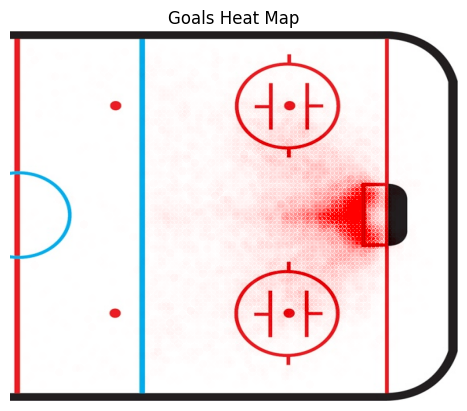

In [118]:
# plot goals heat map

def plot_heatmap(df: pd.DataFrame, title: str, alpha: float = 0.005) -> None:
    img = plt.imread("/usr/src/app/playground/images/half_rink_diagram.jpg")
    plt.imshow(
        img, 
        zorder=0, 
        extent=[
            # df.x_coord_norm.min(),
            # df.x_coord_norm.max(),
            # df.y_coord_norm.min(),
            # df.y_coord_norm.max(),
            # 0, 100, -43, 43,
            -3, 106, -45, 45,
        ],
    )
    ax = sns.scatterplot(
        data=df,
        x="x_coord_norm", 
        y="y_coord_norm", 
        hue="event_type",
        alpha=alpha,
        zorder=1,
        # palette=["orange"],
        # palette=["y"],
        # palette=["purple", "y"],
        palette={"goal": "red", "shot-on-goal": "orange", "missed-shot": "yellow"},
    )

    # hide axis
    ax.axis("off")

    # hide legend
    ax.get_legend().set_visible(False)

    # add title
    ax.set_title(title)

    plt.show()
    

plot_heatmap(
    df=df.loc[df.event_type == "goal"], 
    title="Goals Heat Map",
)

## Build an xG model

In [16]:
def get_df_per_game_stats(df: pd.DataFrame, preds_col: str) -> pd.DataFrame:
    return (
        df
        .groupby(by=["game_id"])
        .agg(
            goals_cnt=("is_goal", "sum"),
            xgoals_cnt=(preds_col, "sum"),
        )
    )

def evaluate_model_performance(
    df: pd.DataFrame, 
    df_per_game_stats: pd.DataFrame, 
    preds_col: str
) -> None:
    roc_auc = roc_auc_score(y_true=df.is_goal, y_score=df[preds_col])
    mape_per_game = mean_absolute_percentage_error(
        y_true=df_per_game_stats.goals_cnt, 
        y_pred=df_per_game_stats.xgoals_cnt,
    )
    
    print(f"ROC AUC score: {roc_auc:,.3f}")
    print(f"MAPE score (per game): {mape_per_game:,.3f}")

In [17]:
def get_filtered_players(df: pd.DataFrame, lower_q: float = 0.00, upper_q: float = 1.00) -> pd.Series:
    """Get list of players, filtered by number of shots.
    
    The idea behind this exercise is to filter out outlier (the least and most frequent shooters)
    that can have a negative impact on the xG model.
    """
    df_players_shots_stats = (
        df
        .groupby(by=["shooting_player_id"])
        .agg(
            seasons_cnt=("season", "nunique"),
            shots_cnt=("game_id", "count"),
            unique_games_cnt=("game_id", "nunique"),
        )
        .reset_index()
    )

    shots_lower_q = df_players_shots_stats.shots_cnt.quantile(lower_q)
    shots_upper_q = df_players_shots_stats.shots_cnt.quantile(upper_q)

    df_players_filtered = (
        df_players_shots_stats
        .query(f"{shots_lower_q} < shots_cnt < {shots_upper_q}")
    )
    
    print(f"- all players count: {df.shooting_player_id.nunique():,.0f}")
    print(f"- filtered players count: {df_players_filtered.shooting_player_id.nunique():,.0f}")
    
    return df_players_filtered.shooting_player_id


filtered_players = get_filtered_players(df=df, lower_q=.05)

- all players count: 1,322
- filtered players count: 1,231


#### 1) Baseline probability model

Probability of goal per every X/Y coordinates combination.

In [18]:
# create model

# minimal number of shots to consider the coordinates combination
MIN_SHOTS_CNT = 10

model_1 = (
    df
    # .loc[df.x_coord_norm >= 0]
    .loc[(df.x_coord_norm >= 0) & (df.shooting_player_id.isin(filtered_players))]
    .groupby(by=["coords_combination"])
    
    # compute xG value per every coordinates combination
    .agg(
        shots_cnt=("event_type", "count"),
        goals_cnt=("event_type", lambda x: x.eq("goal").sum()),
        xg=("event_type", lambda x: x.eq("goal").mean()),
    )
    
    # filter out rows with insignificant value
    .query(f"shots_cnt > {MIN_SHOTS_CNT}")
    
    # save coordinates to xG value mapping
    .xg.to_dict()
)

In [19]:
# evaluate model performance

preds_col = "model_1_preds"

df[preds_col] = df.coords_combination.map(model_1).fillna(0)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.739
MAPE score (per game): 0.404


In [20]:
# xG in 2024 SC final games between Edmonton and Florida

for game_id in (2023030411, 2023030412, 2023030413, 2023030414, 2023030415, 2023030416, 2023030417):
    game_stats = df_per_game_stats.loc[game_id]
    print(f"{game_id=}, goals={game_stats.goals_cnt:,.0f}, xgoals={game_stats.xgoals_cnt:,.3f}")

game_id=2023030411, goals=3, xgoals=5.613
game_id=2023030412, goals=4, xgoals=3.685
game_id=2023030413, goals=7, xgoals=5.393
game_id=2023030414, goals=9, xgoals=7.745
game_id=2023030415, goals=8, xgoals=5.711
game_id=2023030416, goals=5, xgoals=3.623
game_id=2023030417, goals=3, xgoals=4.762


#### 2) Probability model per every strength state (equal strengths, PP, SH)

Probability of goal per every X/Y coordinates combination, and strength state.

In [21]:
# create model

# minimal number of shots to consider the coordinates combination
MIN_SHOTS_CNT = 3

model_2 = (
    df
    # .loc[df.x_coord_norm >= 0]
    .loc[(df.x_coord_norm >= 0) & (df.shooting_player_id.isin(filtered_players))]
    .groupby(by=["coords_strength_combination"])
    
    # compute xG value per every coordinates combination
    .agg(
        shots_cnt=("event_type", "count"),
        goals_cnt=("event_type", lambda x: x.eq("goal").sum()),
        xg=("event_type", lambda x: x.eq("goal").mean()),
    )
    
    # filter out rows with insignificant value
    .query(f"shots_cnt > {MIN_SHOTS_CNT}")
    
    # save coordinates to xG value mapping
    .xg.to_dict()
)

In [22]:
# evaluate model performance

preds_col = "model_2_preds"

df[preds_col] = df.coords_strength_combination.map(model_2).fillna(0)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.755
MAPE score (per game): 0.388


In [23]:
# xG in 2024 SC final games between Edmonton and Florida

for game_id in (2023030411, 2023030412, 2023030413, 2023030414, 2023030415, 2023030416, 2023030417):
    game_stats = df_per_game_stats.loc[game_id]
    print(f"{game_id=}, goals={game_stats.goals_cnt:,.0f}, xgoals={game_stats.xgoals_cnt:,.3f}")

game_id=2023030411, goals=3, xgoals=5.432
game_id=2023030412, goals=4, xgoals=3.107
game_id=2023030413, goals=7, xgoals=4.878
game_id=2023030414, goals=9, xgoals=7.248
game_id=2023030415, goals=8, xgoals=5.196
game_id=2023030416, goals=5, xgoals=3.591
game_id=2023030417, goals=3, xgoals=4.646


#### 3) Combination of the two models above.

In [24]:
# evaluate model performance

preds_col = "model_3_preds"

df[preds_col] = df.coords_strength_combination.map(model_2).fillna(df.model_1_preds)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.773
MAPE score (per game): 0.398


#### 4) ML based

In [25]:
numerical_columns = [
    "x_coord_norm", 
    "y_coord_norm", 
    "distance_from_goal", 
    "angle", 
    # "period", 
    # "time_in_period_seconds",
    "time_between_shots",
    "is_empty_net",
]

categorical_columns = [
    "shot_type",
    "strength", 
]

In [26]:
# define column transformer

categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")), 
        ("encoder", OneHotEncoder()),
    ]
)
numerical_transformer = Pipeline(
   steps=[
       # ("imputer", KNNImputer()),
       ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
       ("scaler", MinMaxScaler()),
   ]
)
column_transformer = ColumnTransformer(
   transformers=[
     ("numeric", numerical_transformer, numerical_columns),
     ("categorical", categorical_transformer, categorical_columns),
   ]
)

In [27]:
# define X and y columns

X_cols = [*numerical_columns, *categorical_columns]
y_col = "is_goal"

In [28]:
# fit a pipeline object on the whole data set

pipeline = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        # ("model", LogisticRegression(max_iter=10_000)),
        ("model", DecisionTreeClassifier(max_depth=18)),
        # ("model", KNeighborsClassifier()), 
        # ("model", GradientBoostingClassifier()), 
    ]
)

pipeline.fit(
    # X=df[X_cols],
    # y=df[y_col],
    X=df.loc[(df.x_coord_norm >= 0) & (df.shooting_player_id.isin(filtered_players)), X_cols], 
    y=df.loc[(df.x_coord_norm >= 0) & (df.shooting_player_id.isin(filtered_players)), y_col],
)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['x_coord_norm',
                                                   'y_coord_norm',
                                                   'distance_from_goal',
                                                   'angle',
                                                   'time_between_shots',
                                                   'is_empty_net']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['shot_type', 'strength'])])),
                ('model', DecisionTreeClassifier(max_depth=18))])

In [29]:
# evaluate model performance

preds_col = "model_4_preds"

df[preds_col] = pipeline.predict_proba(df[X_cols])[:, 1]

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.854
MAPE score (per game): 0.362


In [30]:
# xG in 2024 SC final games between Edmonton and Florida

for game_id in (2023030411, 2023030412, 2023030413, 2023030414, 2023030415, 2023030416, 2023030417):
    game_stats = df_per_game_stats.loc[game_id]
    print(f"{game_id=}, goals={game_stats.goals_cnt:,.0f}, xgoals={game_stats.xgoals_cnt:,.3f}")

game_id=2023030411, goals=3, xgoals=5.169
game_id=2023030412, goals=4, xgoals=4.858
game_id=2023030413, goals=7, xgoals=6.092
game_id=2023030414, goals=9, xgoals=7.908
game_id=2023030415, goals=8, xgoals=5.480
game_id=2023030416, goals=5, xgoals=2.992
game_id=2023030417, goals=3, xgoals=4.031


In [31]:
# moneypuck's values 

print(round(5.61 + 1.88, 2))
print(round(1.39 + 2.92, 2))
print(round(4.48 + 3.64, 2))
print(round(2.49 + 4.94, 2))
print(round(3.80 + 3.21, 2))
print(round(1.94 + 2.84, 2))
print(round(2.39 + 2.15, 2))

7.49
4.31
8.12
7.43
7.01
4.78
4.54


## xG models comparison

In [32]:
# perc of shots with x_goals equal to 0

for i in range(1, 5):
    zero_vals_perc = df[f"model_{i}_preds"].eq(0).sum() / len(df) * 100
    print(f"model_{i}: {zero_vals_perc:,.2f} %")

model_1: 14.44 %
model_2: 24.70 %
model_3: 20.94 %
model_4: 20.04 %


```
version 1)

+---------------+---------------+---------------+
| model id      | ROC AUC score | MAPE score    |
+---------------+---------------+---------------+
| 1             |         0.740 |         0.405 |
| 2             |         0.756 |         0.389 |
| 3             |         0.773 |         0.399 |
| 4             |         0.855 |         0.362 |
+---------------+---------------+---------------+

version 2) filtered players anomalies

+---------------+---------------+---------------+
| model id      | ROC AUC score | MAPE score    |
+---------------+---------------+---------------+
| 1             |         0.738 |         0.400 |
| 2             |         0.749 |         0.385 |
| 3             |         0.768 |         0.395 |
| 4             |         0.847 |         0.361 |
+---------------+---------------+---------------+
```

## Detect players who outperform/underperform relative to the xG

In [44]:
UHC_ROSTER_PLAYER_IDS = [
    # Fowrwards
    8475760, # Nick Bjugstad
    8479619, # Michael Carcone
    8483431, # Logan Cooley
    8478474, # Lawson Crouse
    8482659, # Josh Doan
    8482699, # Dylan Guenther
    8480849, # Barrett Hayton
    8479343, # Clayton Keller
    8477021, # Alex Kerfoot
    8481711, # Matias Maccelli
    8480855, # Jack McBain
    8477070, # Liam O'Brien
    8477951, # Nick Schmaltz

    # Defensmen
    8478831, # Kevin Stenlund
    8474013, # Ian Cole
    8480434, # Sean Durzi
    8480891, # Michael Kesselring
    8478507, # John Marino
    8479410, # Mikhail Sergachev
    8479976, # Juuso Valimaki

    # Goalies
    8478971, # Connor Ingram
    8478872, # Karel Vejmelka
]

MODEL_V = "model_4"
TEAM_ID = 53 # Arizona Coyotes
SEASON = 2023

In [382]:
cols = [
    "full_name", "position_code", "games_played", "games_cnt", 
    "shots_cnt", "shoot_perc", "g_cnt", "xg_cnt", "g_minus_xg",
]

players_general_info = (
    df_players
    .loc[df_players.player_id.isin(UHC_ROSTER_PLAYER_IDS)]
    .drop_duplicates("player_id")
    .set_index("player_id")
)

players_stats = (
    df
    .loc[
        (df.shooting_player_id.isin(UHC_ROSTER_PLAYER_IDS)) 
        # & (df.season == SEASON)
    ]
    .groupby(by=["shooting_player_id"])
    .agg(
        games_cnt=("game_id", "nunique"),
        shots_cnt=("game_id", "count"),
        shoot_perc=("is_goal", "mean"),
        g_cnt=("is_goal", "sum"),
        xg_cnt=(f"{MODEL_V}_preds", "sum"),
    )
    
    # create "goals - expected goals" stat
    # (positive value = outperforming player; negative values = underperforming player)
    .assign(
        g_minus_xg=lambda _df: (_df.g_cnt - _df.xg_cnt).round(2),
        full_name=lambda _df: (_df.index.map(players_general_info.full_name)),
        position_code=lambda _df: (_df.index.map(players_general_info.position_code)),
        games_played=lambda _df: (_df.index.map(players_general_info.games_played)),
    )

    # remove players that didn't shoot in many games
    .query("games_cnt >= 10")
    
    # sort values
    .sort_values(by=["g_minus_xg"], ascending=[False])
    
    # sort columns
    .loc[:, cols]
    
    # update types
    .astype({"games_played": "int"})
)


players_stats

,full_name,position_code,games_played,games_cnt,shots_cnt,shoot_perc,g_cnt,xg_cnt,g_minus_xg
shooting_player_id,,,,,,,,,
8479343,Clayton Keller,R,78,275,1036,0.107143,111,89.219255,21.78
8477951,Nick Schmaltz,C,79,236,745,0.110067,82,72.120017,9.88
8479619,Michael Carcone,L,74,87,220,0.122727,27,17.932095,9.07
8482699,Dylan Guenther,R,45,73,248,0.096774,24,18.469798,5.53
8475760,Nick Bjugstad,C,76,243,697,0.088953,62,57.503962,4.50
8479410,Mikhail Sergachev,D,34,274,753,0.033201,25,23.564953,1.44
8482659,Josh Doan,R,11,10,31,0.161290,5,3.888982,1.11
8483431,Logan Cooley,C,82,75,216,0.087963,19,17.906203,1.09
8478474,Lawson Crouse,L,81,247,719,0.098748,71,70.164060,0.84


## Plot player shots heatmap

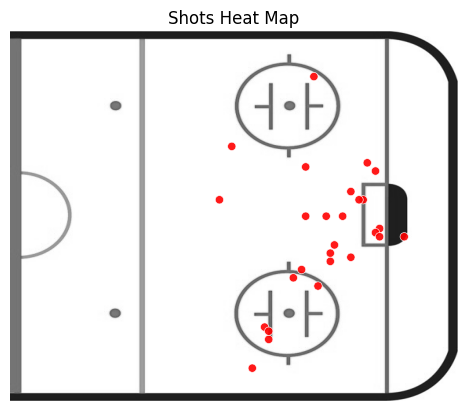

In [183]:
plot_heatmap(
    # df=df.loc[df.shooting_player_id == 8479619],
    df=df.loc[(df.shooting_player_id == 8479619) & (df.event_type == "goal")],
    # df=df.loc[(df.shooting_player_id == 8479619) & (df.event_type.isin(["goal", "shot-on-goal"]))],
    title="Shots Heat Map",
    alpha=0.9,
)

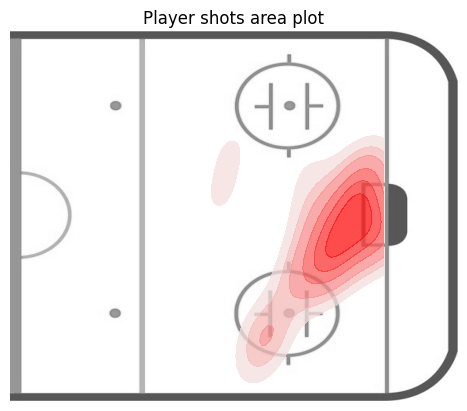

In [354]:
def plot_heatmap_area(df: pd.DataFrame, title: str = "KDE plot") -> None:
    # read rink diagram
    img = plt.imread("/usr/src/app/playground/images/half_rink_diagram.jpg")
    plt.imshow(img, zorder=0, extent=[-3, 106, -45, 45], alpha=0.75)
    
    scaler = preprocessing.MinMaxScaler()
    g_minus_gx = df["is_goal"] - df[f"{MODEL_V}_preds"]
    weigths = scaler.fit_transform(g_minus_gx.values.reshape(-1, 1)).reshape(-1)
    
    # create KDE plot
    ax = sns.kdeplot(
        data=df,
        x="x_coord_norm", 
        y="y_coord_norm", 
        weights=gaussian_filter(df[f"{MODEL_V}_preds"], sigma=3),
        # weights=df[f"{MODEL_V}_preds"],
        # weights=weigths,
        # weights=gaussian_filter(weigths, sigma=3),
        # cmap=sns.color_palette("light:b", as_cmap=True),
        cmap=sns.color_palette("light:r", as_cmap=True),
        # cmap="bwr",
        fill=True,
        # clip=((0, 105), (-43, 43)),
        clip=((0, 88), (-43, 43)),
        cut=10,
        alpha=0.75,
        thresh=0.25,
        levels=7,
        bw_adjust=0.75,
    )

    # hide axis
    ax.axis("off")

    # add title
    ax.set_title(title)

    plt.show()


plot_heatmap_area(
    # df=df.loc[df.shooting_player_id == 8479619],
    df=df.loc[(df.shooting_player_id == 8479619) & (df.event_type == "goal")],
    # df=df.loc[(df.shooting_player_id == 8479619)],
    title="Player shots area plot",
)

## Plot player shots area statistics

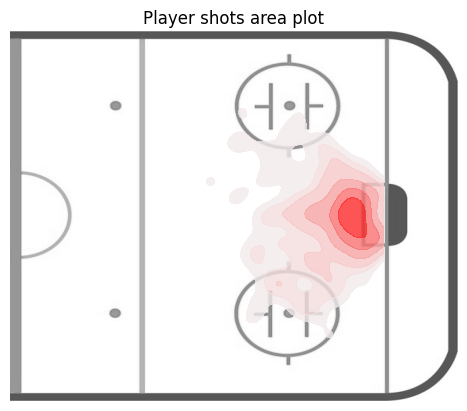

In [378]:
def plot_heatmap_area(df: pd.DataFrame, title: str = "KDE plot") -> None:
    # read rink diagram
    img = plt.imread("/usr/src/app/playground/images/half_rink_diagram.jpg")
    plt.imshow(img, zorder=0, extent=[-3, 106, -45, 45], alpha=0.75)
    
    scaler = preprocessing.MinMaxScaler()
    g_minus_gx = df["is_goal"] - df[f"{MODEL_V}_preds"]
    weigths = scaler.fit_transform(g_minus_gx.values.reshape(-1, 1)).reshape(-1)
    
    # create KDE plot
    ax = sns.kdeplot(
        data=df,
        x="x_coord_norm", 
        y="y_coord_norm", 
        # weights=gaussian_filter(df[f"{MODEL_V}_preds"], sigma=3),
        # weights=df[f"{MODEL_V}_preds"],
        # weights=weigths,
        # weights=gaussian_filter(weigths, sigma=3),
        # cmap=sns.color_palette("light:b", as_cmap=True),
        cmap=sns.color_palette("light:r", as_cmap=True),
        # cmap="bwr",
        fill=True,
        # clip=((0, 105), (-43, 43)),
        clip=((0, 88), (-43, 43)),
        cut=10,
        alpha=0.8,
        thresh=0.2,
        levels=7,
        bw_adjust=0.5,
    )

    # hide axis
    ax.axis("off")

    # add title
    ax.set_title(title)

    plt.show()


# Goalies
# 8478971, # Connor Ingram
# 8478872, # Karel Vejmelka

plot_heatmap_area(
    df=df.loc[(df.goalie_in_net_id == 8478872) & (df.event_type == "goal")],
    title="Player shots area plot",
)